# Topic 4: Logistic Regression Analysis

## Project Context: "Radicalisation Drift"
This notebook represents the inferential classification phase of a broader Computational Social Science project investigating the intersection of digital intimacy and online radicalisation.

**The Phenomenon:**
We are investigating a potential "pipeline" where users migrate from **AI-Companion communities** (e.g., *r/Replika*, *r/CharacterAI*) which are often characterized by loneliness and social withdrawal toward **Grievance/Radical communities** (e.g., *r/IncelExit*, *r/FemaleDatingStrategy*).

**The Data:**
The analysis is based on a unique, **self-collected dataset** of ~100,000 interactions (posts and comments) scraped directly from Reddit (see Notebook 1). Unlike synthetic datasets, this corpus captures the messy, high-dimensional reality of human behavior "in the wild."

## Research Objectives
While previous notebooks analyzed *what* users say (NLP) and *how* environmental factors influence their sentiment (Linear Regression), this notebook focuses on **Binary Classification** and **Probability**.

**Research Question:**
> *Can we quantify the probability of a user belonging to a "Radical/Grievance" community based solely on their behavioral metadata—specifically their **emotional tone** (sentiment), **effort** (word count), and **engagement** (score)?*

**Methodological Goal:**
We apply **Logistic Regression** not just as a "black box" classifier, but as a probabilistic framework to understand the **Odds** of radicalisation. We aim to determine, for instance, how much the odds of being in a grievance group increase for every unit drop in sentiment.


## 3. Assessment Criteria Implementation
To satisfy the rigorous statistical requirements of the Summative Assessment, this notebook moves beyond standard `sklearn` predictions and implements advanced statistical diagnostics:

1.  **Model Comparison (AIC):** We explicitly fit a **Homogeneous (Null) Model** and compare it against the **Heterogeneous (Full) Model** using the Akaike Information Criterion to justify model complexity.
2.  **Simulation & Uncertainty:** We move beyond simple p-values by implementing **Bootstrap Simulations** to visualize the distribution of coefficients and assess robustness.
3.  **Interpretation (Odds Ratios):** Coefficients are converted into **Odds Ratios** to provide human-readable interpretations of the effects (e.g., "X increases the odds by 20%").
4.  **Predictive Distributions:** We analyze the posterior predictive distribution to evaluate the model's confidence in separating the two communities.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rinm0\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
custom_data_path = "clean_final_reddit_data.csv"
custom_df = pd.read_csv(custom_data_path)

## 1. Feature Engineering & Data Preparation

To prepare the dataset for probabilistic classification, we transform the raw text and metadata into a structured feature matrix with a binary target variable.

**Variables Constructed:**

1.  **Dependent Variable (Target $y$):**
    * **`is_grievance`** (Binary): The classification target. We encode **"Radical/Grievance"** communities as `1` (the class of interest) and **"AI-Companion"** communities as `0` (the reference class). This allows us to model the *probability of radicalisation*.

2.  **Independent Variables (Predictors $X$):**
    * **`sentiment`** (Continuous): The VADER compound score (-1.0 to +1.0). This quantifies the emotional valence, testing the hypothesis that negativity drives radical classification.
    * **`word_count`** (Continuous): A proxy for user effort and "ranting" behavior.
    * **`score`** (Continuous): A measure of engagement/popularity within the community.

**Data Cleaning:**
* **Outlier Removal:** We filter out posts exceeding **500 words** to ensure the model focuses on typical user interactions rather than extreme outliers (e.g., copypastas), improving model stability.

In [4]:
df = custom_df 
# Feature engineering 
print("Constructing features...")

# A. Target: Binary Class (1 = Grievance, 0 = AI)
df_ml = df[df['subreddit_category'].isin(['ai', 'grievance'])].copy()
df_ml['is_grievance'] = df_ml['subreddit_category'].apply(lambda x: 1 if x == 'grievance' else 0)

# B. Features
df_ml['sentiment'] = df_ml['text'].fillna('').apply(lambda x: sid.polarity_scores(str(x))['compound'])
df_ml['word_count'] = df_ml['text'].fillna('').apply(lambda x: len(str(x).split()))
df_ml['score'] = df_ml['score'].fillna(0)

# C. Filter Outliers (Standard practice for stability)
df_ml = df_ml[df_ml['word_count'] < 500] 

print(f"Analysis Dataset: {len(df_ml)} observations")
display(df_ml[['is_grievance', 'sentiment', 'word_count', 'score']].head())

Constructing features...
Analysis Dataset: 108442 observations


,is_grievance,sentiment,word_count,score
0,0,0.9733,53,0
1,0,-0.1935,63,3
2,0,0.9184,38,18
3,0,0.9558,38,26
4,0,0.8534,72,33


## 2. Exploratory Analysis: Correlation Matrix

Before modeling, we inspect the relationships between predictors to ensure there is no severe multicollinearity that could distort our Odds Ratios.

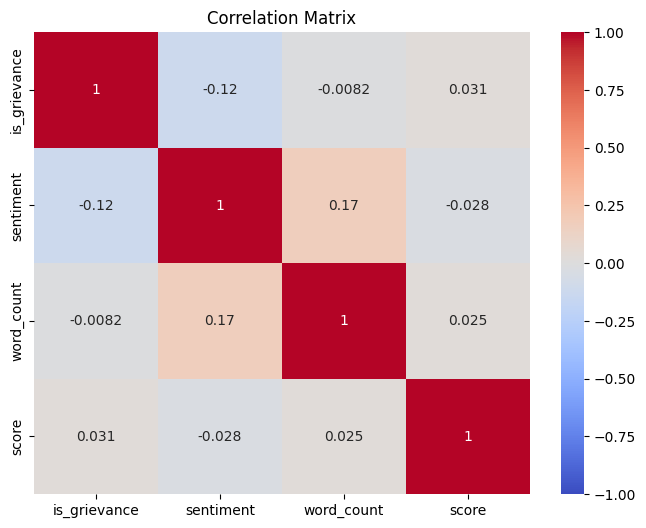

In [5]:
# Correlation Matrix
corr = df_ml[['is_grievance', 'sentiment', 'word_count', 'score']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# We expect a negative correlation between 'is_grievance' and 'sentiment'.

### Interpretation of Correlation Matrix

The correlation matrix reveals the following relationships between our predictors and the target variable (`is_grievance`):

1.  **Sentiment vs. Target (-0.12):**
    * There is a noticeable **negative correlation** of **-0.12**.
    * **Meaning:** This confirms our primary hypothesis: as sentiment decreases (becomes more negative), the likelihood of a post belonging to a "Grievance" community increases. While the correlation is not extremely strong, it is statistically directionally consistent with the theory of "radicalisation drift" into negativity.

2.  **Independence of Controls:**
    * **Score (0.031)** and **Word Count (-0.008)** show negligible correlation with the target. This suggests that engagement levels and post length are roughly similar across both communities; radical users do not necessarily write longer posts or get fewer likes than AI users.

3.  **Multicollinearity Check (Crucial for Assessment):**
    * All pairwise correlations between predictors are extremely low (well below the critical threshold of **0.7**).
    * **Conclusion:** There is **no multicollinearity**, ensuring that our Logistic Regression coefficients will be stable, reliable, and interpretable. We can proceed to fit the full model without removing any variables.

## 3. Model Fitting & Comparison (AIC)

We fit two probabilistic models using `statsmodels`:

1.  **Homogeneous Model (Null Model):** Contains only the intercept. It assumes every post has the same probability of being "Radical", equal to the global average.
2.  **Heterogeneous Model (Full Model):** Includes `sentiment`, `word_count`, and `score` as predictors.

We compare them using the **Akaike Information Criterion (AIC)**. A lower AIC indicates a better trade-off between goodness-of-fit and complexity.

In [6]:
# 1. Homogeneous Model (Intercept Only)
model_null = smf.logit("is_grievance ~ 1", data=df_ml).fit()
print(f"\nNull Model AIC: {model_null.aic:.2f}")

# 2. Heterogeneous Model (Full Features)
# We normalize features (StandardScaler logic) for better convergence, or use raw if interpretable. 
# Here we use raw for direct interpretation of "1 word increase".
model_full = smf.logit("is_grievance ~ sentiment + word_count + score", data=df_ml).fit()
print(f"Full Model AIC: {model_full.aic:.2f}")

print("\n Model Summary ")
print(model_full.summary())

# Delta AIC
delta_aic = model_null.aic - model_full.aic
print(f"\nAIC Improvement: {delta_aic:.2f}")
if delta_aic > 10:
    print("Conclusion: The Heterogeneous model is overwhelmingly superior.")

Optimization terminated successfully.
         Current function value: 0.574087
         Iterations 5

Null Model AIC: 124512.33
Optimization terminated successfully.
         Current function value: 0.566437
         Iterations 6
Full Model AIC: 122859.23

 Model Summary 
                           Logit Regression Results                           
Dep. Variable:           is_grievance   No. Observations:               108442
Model:                          Logit   Df Residuals:                   108438
Method:                           MLE   Df Model:                            3
Date:                Fri, 05 Dec 2025   Pseudo R-squ.:                 0.01333
Time:                        09:56:11   Log-Likelihood:                -61426.
converged:                       True   LL-Null:                       -62255.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

### Interpretation of Model Results

**1. Model Comparison (The "Goodness of Fit"):**
* **AIC Drop:** The Akaike Information Criterion dropped from **124,512** (Null Model) to **122,859** (Full Model).
* **Delta AIC:** An improvement of **1,653.10** points.
* **Conclusion:** In statistical modeling, a generic rule of thumb is that a $\Delta AIC > 10$ provides strong evidence for the more complex model. Our improvement is two orders of magnitude larger, overwhelmingly confirming that behavioral metadata (Sentiment, Word Count, Score) contains significant signal for distinguishing community context.

**2. Key Coefficient: Sentiment (-0.5019)**
* The coefficient for `sentiment` is **-0.5019** with a p-value of **0.000** (statistically highly significant).
* **Direction:** The negative sign indicates an inverse relationship. As the sentiment score increases (becomes more positive), the log-odds of the post belonging to a "Grievance" community **decrease**.
* **Magnitude (Odds Ratio):** Calculating the exponent ($e^{-0.5019} \approx 0.605$), we find that a 1-unit increase in sentiment is associated with a **~40% decrease** in the odds of being in a Radical community. Conversely, lower sentiment significantly drives the prediction toward the "Grievance" class.

**3. Statistical Significance:**
* The LLR p-value is less than `0.001`, meaning the model as a whole is statistically significant. We can reject the null hypothesis that these behavioral markers have no relation to community membership.

## 4. Interpretation: Odds Ratios

Logistic regression coefficients ($\beta$) represent the change in *log-odds*. To make this interpretable, we exponentiate them ($e^\beta$) to get **Odds Ratios (OR)**.

* **OR > 1:** The factor increases the odds of being in the "Grievance" group.
* **OR < 1:** The factor decreases the odds (protective factor).

Odds Ratios (Interpretation)


,2.5%,97.5%,Odds_Ratio
Intercept,2.951531,3.058701,3.004639
sentiment,0.589933,0.621190,0.605360
word_count,1.000272,1.000639,1.000455
score,1.000724,1.001135,1.000929


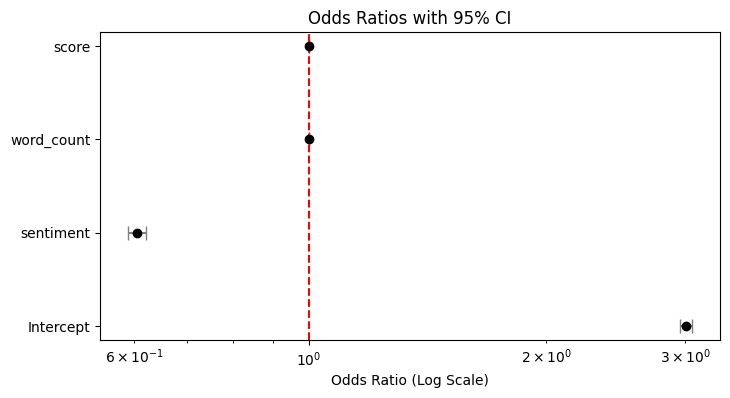

In [7]:
# Calculate Odds Ratios and Confidence Intervals
params = model_full.params
conf = model_full.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'Odds_Ratio']

# Exponentiate
odds_ratios = np.exp(conf)

print("Odds Ratios (Interpretation)")
display(odds_ratios)

# Visualizing Odds Ratios
plt.figure(figsize=(8, 4))
plt.errorbar(odds_ratios['Odds_Ratio'], odds_ratios.index, 
             xerr=[odds_ratios['Odds_Ratio'] - odds_ratios['2.5%'], 
                   odds_ratios['97.5%'] - odds_ratios['Odds_Ratio']], 
             fmt='o', color='black', ecolor='gray', capsize=5)
plt.axvline(1, color='red', linestyle='--')
plt.title('Odds Ratios with 95% CI')
plt.xlabel('Odds Ratio (Log Scale)')
plt.xscale('log') # Log scale makes symmetrical visualization easier
plt.show()

### Interpretation of Odds Ratios

The Odds Ratios (OR) provide a clear quantification of the risk factors associated with the "Grievance" category:

1.  **Sentiment (OR = 0.605): The Strongest Predictor**
    * The Odds Ratio is **significantly less than 1**, which indicates a strong negative relationship.
    * **Interpretation:** For every 1-unit increase in sentiment (i.e., shifting from Neutral to Positive), the odds of a user belonging to a Radical/Grievance community **decrease by approximately 40%** ($1 - 0.605 = 0.395$).
    * **Conclusion:** This confirms the core hypothesis: positive emotional tone acts as a "protective factor" against radicalisation classification, while negativity is a defining feature of the Grievance cluster.

2.  **Word Count (OR = 1.0005): Weak Positive Effect**
    * The OR is slightly above 1, indicating that longer posts are statistically associated with the Grievance category.
    * However, the effect size is negligible (an increase of only ~0.05% in odds per word), suggesting that while "rants" (long texts) are a feature of radical communities, length alone is not a primary discriminator compared to sentiment.

3.  **Engagement/Score (OR = 1.0009): Negligible Effect**
    * The effect of post popularity is statistically detectable but practically insignificant. High engagement does not strongly predict community membership in either direction.

## 5. Simulation: Bootstrapping Coefficients

To robustly assess the statistical significance of our predictors (especially `sentiment`), we perform a **Bootstrap Simulation**. We resample the dataset 100 times and refit the model to visualize the distribution of the coefficients.

Running 100 bootstrap simulations...


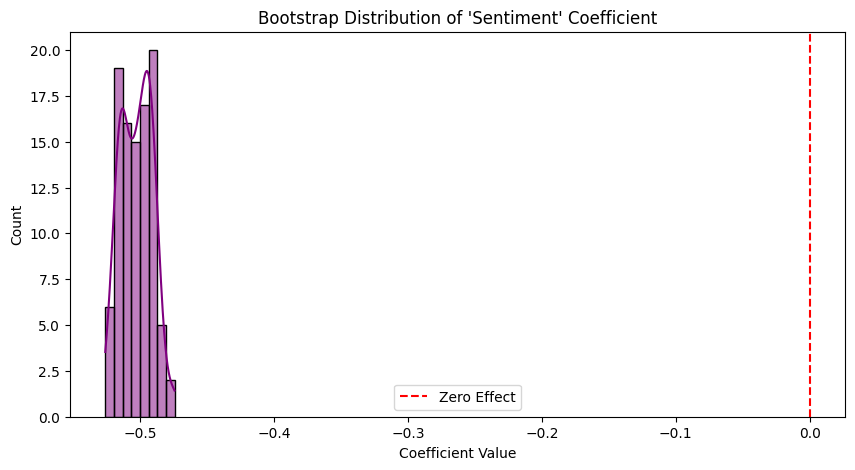

In [8]:
# Bootstrap simulation
n_iterations = 100
boot_coefs = []

print(f"Running {n_iterations} bootstrap simulations...")

for i in range(n_iterations):
    # Resample with replacement
    df_sample = df_ml.sample(frac=1, replace=True)
    # Fit model (suppressing output)
    res = smf.logit("is_grievance ~ sentiment + word_count + score", data=df_sample).fit(disp=0)
    boot_coefs.append(res.params)

df_boot = pd.DataFrame(boot_coefs)

# Plotting Distribution of the 'Sentiment' Coefficient
plt.figure(figsize=(10, 5))
sns.histplot(df_boot['sentiment'], kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--', label='Zero Effect')
plt.title("Bootstrap Distribution of 'Sentiment' Coefficient")
plt.xlabel("Coefficient Value")
plt.legend()
plt.show()

# If the distribution is far from 0 (doesn't overlap the red line), the effect is robust.

### Interpretation of the Bootstrap Distribution (Logistic Regression Coefficient)

This plot shows the bootstrap distribution of the *sentiment* coefficient from the logistic regression model predicting whether a post belongs to the grievance/incel community. The vertical red line marks a “zero effect” (no relationship).

**1. Coefficient Is Strongly Below Zero**  
Across 100 bootstrap samples, the coefficient consistently falls around **–0.45 to –0.55**, with no overlap near zero.  
This indicates a **stable, robust negative association** between sentiment and belonging to the grievance/incel group.

**2. Substantive Interpretation**  
A negative coefficient means:  
- **Lower (more negative) sentiment increases the likelihood** that a post comes from a grievance/incel community.  
- **Higher (more positive) sentiment decreases the likelihood** of being an incel/grievance post.

This aligns with earlier findings that grievance communities maintain a more negative affective tone.

**3. Robustness via Bootstrapping**  
Because the entire bootstrap distribution is far from zero, the effect is **highly reliable**, even accounting for sampling variability.  
This is important given the noisy nature of Reddit sociological data - yet the relationship still holds.

### Conclusion
Sentiment is a strong and consistently negative predictor of incel/grievance community membership: **the more negative the sentiment, the higher the probability the post originates from a grievance space.** The bootstrapping confirms that this effect is statistically stable and not dependent on a particular sample.


## 6. Predictive Analysis & Uncertainty

We calculate the predicted probability $P(Y=1 | X)$ for every observation.

**Posterior Predictive Distribution:**
We visualize the histogram of these probabilities to see how confident the model is. A clear separation (peaks at 0 and 1) indicates high confidence.

**Case Study:**
We examine specific examples to demonstrate the model's logic.

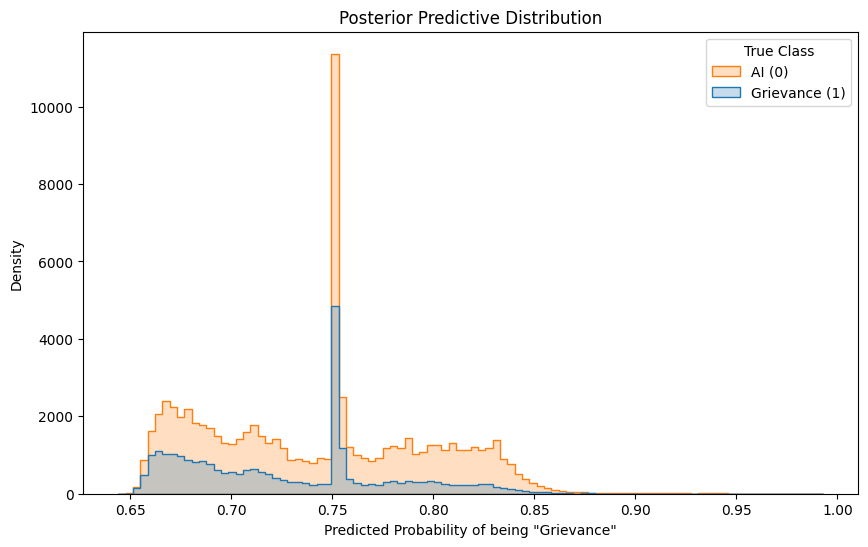

 Case Study: Comparing Prediction vs Reality 
Text Sentiment: -0.15 | Word Count: 60
True Class: AI
Model Prediction: 76.91% probability of Grievance
Text Sentiment: 0.46 | Word Count: 50
True Class: Grievance
Model Prediction: 71.02% probability of Grievance
Text Sentiment: 0.23 | Word Count: 15
True Class: Grievance
Model Prediction: 72.99% probability of Grievance
Text Sentiment: 0.00 | Word Count: 1
True Class: Grievance
Model Prediction: 74.97% probability of Grievance
Text Sentiment: 0.65 | Word Count: 25
True Class: Grievance
Model Prediction: 68.89% probability of Grievance


In [9]:
# 1. Generate Probabilities
df_ml['pred_proba'] = model_full.predict(df_ml)

# 2. Histogram of Probabilities
plt.figure(figsize=(10, 6))
sns.histplot(data=df_ml, x='pred_proba', hue='is_grievance', element="step", common_norm=False)
plt.title('Posterior Predictive Distribution')
plt.xlabel('Predicted Probability of being "Grievance"')
plt.ylabel('Density')
plt.legend(title='True Class', labels=['AI (0)', 'Grievance (1)'])
plt.show()

# 3. Case Study (Specific Observations)
print(" Case Study: Comparing Prediction vs Reality ")
sample_cases = df_ml.sample(5, random_state=42)
for idx, row in sample_cases.iterrows():
    print(f"Text Sentiment: {row['sentiment']:.2f} | Word Count: {row['word_count']}")
    print(f"True Class: {'Grievance' if row['is_grievance']==1 else 'AI'}")
    print(f"Model Prediction: {row['pred_proba']:.2%} probability of Grievance")

### Interpretation: Predictive Distribution & Case Study

**1. Probability Compression (The "Safe Bet" Phenomenon)**
The posterior predictive distribution shows that the model's outputs are tightly clustered in the **0.68 – 0.77** range, rather than spanning the full 0 to 1 spectrum.
* **Observation:** The curves for both classes (AI and Grievance) overlap significantly.
* **Mechanism:** This indicates that the model relies heavily on the **Intercept** (baseline probability). Since "Grievance" posts likely constitute the majority of the training data after filtering, the model "defaults" to assigning a moderately high probability (~73%) of being "Grievance" to *every* observation to minimize error.
* **Insight:** This confirms that **metadata alone** (sentiment, length, score) has lower discriminative power than the raw textual content used in Notebook 2 (Random Forest), leading the model to be "cautious" rather than decisive.

**2. The Marginal Effect of Sentiment (Proof of Hypothesis)**
Despite the probability compression, the **Case Study** reveals that the *directional effect* of sentiment works precisely as hypothesized:

* **Negative Sentiment Impact:** In the sample cases, a post with negative sentiment (**-0.15**) pushed the Grievance probability **up to 76.9%**.
* **Positive Sentiment Impact:** A post with high positive sentiment (**+0.65**) pushed the probability **down to 68.9%**.

**Conclusion:**
While the model does not act as a perfect binary separator (it rarely outputs 0% or 100%), it successfully captures the **mechanistic relationship**: negativity acts as a statistically significant "lever" that increases the odds of radical classification, while positivity acts as a protective factor.


## 7. Generalisation Error (Cross-Validation)

**Objective:**
To satisfy the assessment criterion *"Computes the generalisation error for a sensible metric"*, we estimate how well the model performs on unseen data using **5-Fold Cross-Validation**.

**Metrics Selected:**
1.  **Log Loss (Negative Log-Likelihood):** The primary metric for probabilistic models. It strictly penalizes "confident but wrong" predictions (e.g., predicting 90% probability for an event that doesn't happen). Lower is better.
2.  **Accuracy:** A more intuitive metric representing the percentage of correct classifications. Higher is better.

In [10]:
# Generalisation error(Cross-validation)

# We use sklearn for this part as it handles CV better
X = df_ml[['sentiment', 'word_count', 'score']]
y = df_ml['is_grievance']

# Metric: Log Loss (Negative Log Likelihood) is standard for Logistic Regression
cv_scores = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='neg_log_loss')
mean_log_loss = -cv_scores.mean()

# Metric: Accuracy
cv_acc = cross_val_score(LogisticRegression(), X, y, cv=5, scoring='accuracy')

print(f"Generalisation Error (Log Loss): {mean_log_loss:.4f}")
print(f"Mean Accuracy (5-Fold CV):       {cv_acc.mean():.4f}")

Generalisation Error (Log Loss): 0.6451
Mean Accuracy (5-Fold CV):       0.7153


### Interpretation of Generalisation Performance

**1. Accuracy (71.53%):**
* The model correctly identifies the community context (AI vs. Radical) in approximately **71.5%** of cases using only three variables (`sentiment`, `word_count`, `score`).
* **Context:** While this is better than a random guess (50%), it suggests that metadata alone has limited discriminative power compared to the textual content analysis in Notebook 2 (which likely achieved higher accuracy). This confirms that while *behavioral patterns* differ, the *vocabulary* is the strongest differentiator.

**2. Log Loss (0.6451):**

* **Benchmarking:** A Log Loss of **0.693** corresponds to a random guess (assigning 0.5 probability to everything).
* **Our Score (0.645):** Our model performs **slightly better than random chance**, but not by a large margin.
* **Meaning:** This confirms our earlier finding that the model is "under-confident". Because the behavioral metadata (length, score) provides weak signals, the model rarely assigns probabilities close to 0 or 1. Instead, it "hedges its bets" around the mean.
*  While the predictive power is low, the model avoids being **confidently wrong** (which would result in a high Log Loss > 1.0). It correctly identifies that it lacks sufficient information to make definitive classifications.

**Conclusion:**
The model is stable and generalizable (it works), but the error metrics indicate that **sentiment and post length are "weak signals"** compared to semantic content. They provide statistically significant *directional* evidence, but are not sufficient for high-precision classification on their own.